In [15]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

In [16]:
def GetPixelValue(img, u, v):
    x = max(0, min(u, img.shape[1] - 2))
    y = max(0, min(v, img.shape[0] - 2))
    
    x0, y0 = int(x), int(y)
    x1, y1 = x0 + 1, y0 + 1
    
    xx, yy = x - x0, y - y0  

    I00 = img[y0, x0]  
    I10 = img[y0, x1]   
    I01 = img[y1, x0]   
    I11 = img[y1, x1]   

    Ixy = (1 - xx) * (1 - yy) * I00 + xx * (1 - yy) * I10 + (1 - xx) * yy * I01 + xx * yy * I11

    return float(Ixy)  

In [17]:
class Tracker:
    def __init__(self, img1, img2, kp1):
        self.img1 = img1
        self.img2 = img2
        self.kp1 = kp1
        self.kp2 = [None] * len(kp1)
        self.iteration = 10
        self.half_patch_size = 4
        
    def CalculateOpticalFlow(self): # 效果不好
        for i in range(len(self.kp1)):
            kp = self.kp1[i]
            dx, dy = 0, 0
            last_cost = 0
            
            for i in range(self.iteration):
                H = np.zeros((2, 2), dtype = np.float64)
                g = np.zeros((2, 1), dtype = np.float64)
                J = np.zeros((1, 2), dtype = np.float64)
                
                cost = 0
                
                for x in range(-self.half_patch_size, self.half_patch_size):
                    for y in range(-self.half_patch_size, self.half_patch_size):
                        e = float(GetPixelValue(self.img1, int(kp.pt[0]) + x, int(kp.pt[1]) + y) - GetPixelValue(self.img2, int(kp.pt[0]) + x + dx, int(kp.pt[1]) + y + dy))
                        cost += e ** 2
                        J = -1.0 * np.array([[0.5 * (GetPixelValue(self.img2, int(kp.pt[0])+ x + dx + 1, int(kp.pt[1]) + y + dy) -
                                            GetPixelValue(self.img2, int(kp.pt[0]) + x + dx - 1, int(kp.pt[1]) + y + dy)),
                                            0.5 * (GetPixelValue(self.img2, int(kp.pt[0]) + x + dx, int(kp.pt[1]) + y + dy + 1) - 
                                            GetPixelValue(self.img2, int(kp.pt[0]) + x + dx, int(kp.pt[1]) + y + dy - 1))]])
                        H += J.T @ J
                        g += -J.T * e
            
                if cost > last_cost and i > 0:
                    break
                
                if np.isclose(np.linalg.det(H), 0):
                    break
                
                dp = np.linalg.solve(H, g)
                
                
                dx += dp[0]
                dy += dp[1]
                last_cost = cost
                
                
                if np.linalg.norm(dp) < 1e-2:
                    break
        
            self.kp2[i] = np.array([int(self.kp1[i].pt[0] + dx), int(self.kp1[i].pt[1] + dy)])
        return self.kp2 

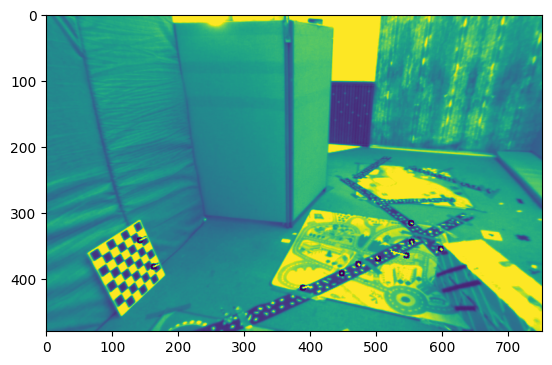

In [18]:
img1 = cv2.imread('../../images/LK1.png', cv2.IMREAD_UNCHANGED)
img2 = cv2.imread('../../images/LK2.png', cv2.IMREAD_UNCHANGED)

detector = cv2.GFTTDetector_create(maxCorners=500, qualityLevel=0.01, minDistance=20)
kp1 = detector.detect(img1)

pt1 = np.array([kp.pt for kp in kp1], dtype=np.float32).reshape(-1, 1, 2)

tracker = Tracker(img1, img2, kp1)

kp2 = tracker.CalculateOpticalFlow()

if kp2 is not None:
    for i, (new, old) in enumerate(zip(kp2, pt1)):
        if new is None:
            continue
        a, b = new.ravel()
        c, d = old.ravel()
        img2 = cv2.circle(img2, (int(a), int(b)), 5, (0, 255, 0), -1)
        img2 = cv2.line(img2, (int(a), int(b)), (int(c), int(d)), (255, 0, 0), 2)
        
plt.imshow(img2)

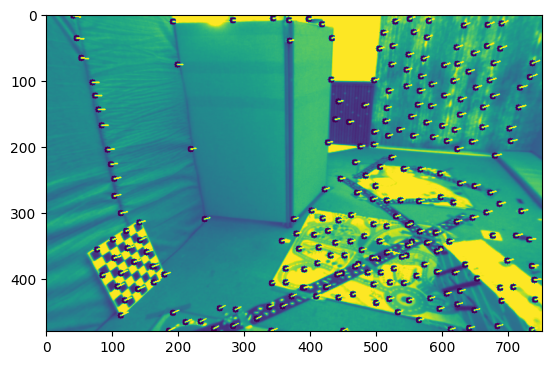

In [19]:

lk_params = dict(winSize=(21, 21), maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

pt2, status, error = cv2.calcOpticalFlowPyrLK(img1, img2, pt1, None, **lk_params)

if pt2 is not None:
    for i, (new, old) in enumerate(zip(pt2, pt1)):
        a, b = new.ravel()
        c, d = old.ravel()
        img2 = cv2.circle(img2, (int(a), int(b)), 5, (0, 255, 0), -1)
        img2 = cv2.line(img2, (int(a), int(b)), (int(c), int(d)), (255, 0, 0), 2)
        
plt.imshow(img2)